### Работа с целевой переменной

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.feature_selection import (
    VarianceThreshold, SelectKBest, chi2, f_regression,
    mutual_info_regression, RFE, SelectFromModel
)
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, accuracy_score, classification_report

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter


#### Цель работы

Познакомиться с основными приемами обработки данных в отношении к целевой переменной: дискретизация, отбор признаков, устранение дисбаланса классов.

#### Содержание работы

1. Загрузите первый датасет для регрессии и познакомьтесь с его структурой.
1. Постройте простую модель регрессии и оцените ее качество.
1. Отберите признаки, наиболее сильно влияющие на значение целевой переменной.
1. Постройте модель на оставшихся данных и оцените ее качество.
1. Загрузите второй датасет для регрессии и постройте распределение целевой переменной.
1. Сгруппируйте значения целевой переменной в категории. Постройте получившееся распределение.
1. Загрузите датасет для классификации. Постройте распределение целевой переменной.
1. Разделите датасет на тестовую и обучающую выборки, постройте и оцените baseline модель классификации.
1. Постройте ту же модель с применением весов классов. Сравните ее качество, сделайте выводы.
1. Выравняйте распределение классов путем оверсемплинга с повторением

#### Методические указания

В предыдущих работах мы занимались предобработкой разных типов данных, ориентируясь на сами характеристики этих данных: их распределения, аномалии, шкалы и так далее. То есть, мы ориентировались на информацию, которую содержат эти переменные изолированно. Однако, для целей моделирования нас в первую очередь интересует то, как тот или иной признак влияет на значение целевой переменной.

В данной работе мы познакомимся с основными операциями обработки данных, которые принимают во внимание соотношение признаков и целевой переменной. Среди них преобразования самой целевой переменной, отбор признаков, работа с несбалансированными датасетами.

##### Отбор признаков по важности

В этой работе мы будем практиковаться на наборах данных с сайте OpenML. Это один их крупных открытых репозиториев датасетов, моделей и алгоритмов машинного обучения, наподобие Kaggle, отличающийся удобным поиском с возможностью фильтрации по датасетам. Что еще более удобно, интеграция с этим репозиторием встроена в библиотеку sklearn, так что можно воспользоваться одной функцией для загрузки датасета. Ее можно импортировать из пакета datasets:

In [126]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt

Для загрузки датасета нам понадобится указать его имя. Если вы ищете датасет на сайте, то его имя указано в заголовке страницы датасета. Для первого примера мы возьмем датасет mtp, содержащий фармокологические данные. Этот датасет подходит для наших целей: в нем довольно много признаков, не все и которых очень показательны для значения целевой переменной. Кроме названия следует указать версию датасета:

In [127]:
df = fetch_openml("mtp", version=1)

df.data.head()

,oz1,oz2,oz3,oz4,oz5,oz6,oz7,oz8,oz9,oz10,...,oz193,oz194,oz195,oz196,oz197,oz198,oz199,oz200,oz201,oz202
0,0.076923,0.325000,0.035088,0.200000,0.162112,0.194562,0.003900,0.060606,0.166667,0.045872,...,0.013874,0.071602,0.056880,0.179132,0.505899,0.039213,0.091327,0.321109,0.127564,0.188387
1,0.230769,0.375000,0.042105,0.333333,0.464191,0.622795,0.077623,0.373737,0.305556,0.192661,...,0.006342,0.186056,0.287438,0.384236,0.683820,0.326584,0.117990,0.456665,0.475618,0.401935
2,0.269231,0.437500,0.052632,0.333333,0.506556,0.531840,0.054374,0.212121,0.333333,0.229358,...,0.005018,0.179544,0.117431,0.384550,0.499219,0.204885,0.155967,0.360441,0.497968,0.407742
3,0.153846,0.357143,0.039474,0.266667,0.352880,0.394131,0.019654,0.171717,0.277778,0.091743,...,0.004801,0.091771,0.145349,0.243064,0.630533,0.023469,0.124430,0.336023,0.134458,0.252258
4,0.153846,0.357143,0.039474,0.266667,0.350523,0.320546,0.013154,0.101010,0.166667,0.110092,...,0.011166,0.130755,0.067583,0.250832,0.516053,0.111398,0.125693,0.332113,0.295913,0.253548


Теперь мы можем оперировать этим датасетом как и любым другим. У датасетов OpenML общий интерфейс: они представляют собой словарь со стандартными ключами. В частности, признаки хранятся по ключу data, а значения целевой переменной - по ключу target. Таким образом, наш датасет уже не нужно разделять на X и y.

Давайте построим распределение целевой переменной:

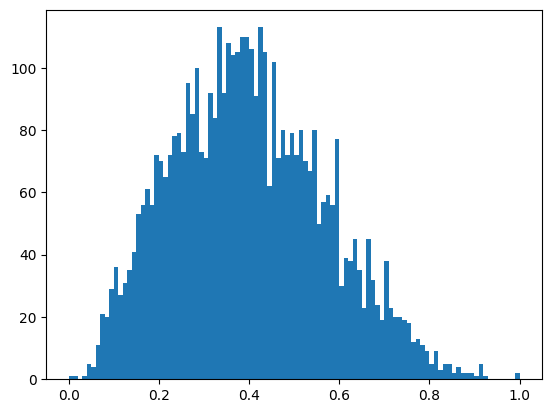

In [128]:
plt.hist(df.target, 100)
_ = plt.plot()

Мы видим, что целевая переменная представляет собой численное значение, что определяет задачу моделирования как регрессию. Кроме того, график показывает, что распределение имеет форму, сходную с нормальным:

Это довольно типичное распределение непрерывной величины в естественных данных. Ничего особенно примечательного здесь нет. Мы его построили справочно, более подробно с распредлением целевой переменной будем работать в следующих пунктах.

##### Построение базовой (baseline) модели

Для того, чтобы оценивать эффективность тех или иных методов обработки данных, желательно понимать, как они влияют на эффективность обучаемых моделей. Для этого до начала любых преобразований данных нужно построить базовую простую модель и оценить ее эффективность. Такая базовая модель часто называется простой baseline или базовой моделью. Такая модель позволяет выбрать те способы изменения исходного датасета, которые увеличивают его предсказательную силу, то есть работают на увеличение точности моделей. Именно с бейзлайном мы будем сравнивать эффективность моделей после преобразования данных.

В любом случае, нам потребуется разделить выборку на обучающую и тестовую для несмещенного оценивания уровня эффективности модели. Для еще более точной оценки, можно использовать перекрестную проверку, можете сделать это самостоятельно, мы же воспользуемся обычным разбиением:

In [129]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.data, df.target, test_size=0.25, random_state=42)

В качестве базовой модели лучше выбрать простую (вычислительно) модель, которая, желательно, обладает высокой интерпретируемостью. Для этого лучше всего подходят линейные модели и деревья решений. В данном случае, воспользуемся моделью линейной регрессии:

In [130]:
from sklearn.linear_model import LinearRegression
baseline = LinearRegression()
baseline.fit(X_train, y_train)
bl_score = baseline.score(X_test, y_test)
bl_score

-1.6511340769310805

В данном случае, мы оценивает тестовую эффективность базовой модели по метрике R-квадрат и сохраняем ее в переменную для дальнейшего использования:

Базовая модель демонстрирует очень низкий уровень эффективности, хуже случайности, хуже предсказания среднего значения. Если бы мы продиагностировали ее, мы бы поняли, что проблема в очень высокой вариативности модели. Самая простая модель уже "переобучается" на наших данных. Это происходит потому, что в данных очень много признаков, каждый их которых добавляет одну степень свободы модели (добавляет один обучаемый коэффициент), что увеличивает её сложность. При этом далеко не все эти признаки нужны для предсказания значения целевой переменной. Как правило, при большом количестве признаков, большинство не несет полезной информации.

Еще будет полезно изобразить линию регрессии на графике, чтобы визуально убедиться в ее низком качестве:

![](https://github.com/koroteevmv/ML_course/blob/main/ML5.4%20target/img/ml54-2.png?raw=true)

##### Определение относительной важности признаков

Для улучшения работы модели нам нужно избавиться от неинформативных, лишних признаков в датасете. Существует множество стратегий, как можно это сделать. Например, мы можем исключать признаки по одному и следить, исключение каких лучше всего влияет на модель. Однако, эта стратегия, называемая "рекурсивное исключение признаков", будет слишком медленно работать, так как у нас больше 200 признаков и чтобы исключить хотя бы один, нам нужно обучить более 200 моделей и так далее.

Также можно попробовать рекурсивное добавление признаков. В этом случае мы выбираем признак, который дает наибольшую эффективность в задаче парной регрессии. После этого также перебором подбираем к нему второй и так далее. Этот способ будет ненамного быстрее и также потребует большого количества вычислительных ресурсов.

Можно использовать парные статистические критерии, которые оценивают степень взаимного влияния двух переменных. Это, например, хи-квадрат, тест Фишера для задач классификации, коэффициент корреляции для регрессии. В данном случае, можно построить коррелограмму, то есть матрицу коэффициентов парной корреляции. Или просто посчитать корреляцию каждого признака с целевой переменной. После этого останется только выбрать те признаки, у которых такой коэффициент выше.

Как мы говорили в лекциях, коэффициенты обученной модели линейной регрессии имеют очень схожий смысл. Можно посмотреть на коэффициенты обученной модели и выбрать те признаки, коэффициенты при который сильнее отличаются от 0. Однако, этот способ, как и оценка коэффициента корреляции, учитывает только линейную связь между конкретным признаком и целевой переменной.

Можно воспользоваться информацией, которую дает обученная нейлинейная модель. Мы уже говорили, что построение, например, дерева решений позволяет оценить относительную важность признаков. Причем эта важность будет учитывать не только линейное, но и более сложное нелинейное и совместное влияние факторов. Плюс, библиотека sklearn позволяет получить эту информацию автоматически, после обучения модели, нам не нужно специально что-то отдельно вычислять.
Так можно узнать, какие из них оказывают наибольшее влияние на значение целевой переменной.

В данном примере мы используем даже не отдельное дерево, которое может очень сильно переобучиться на нашей выборке, а его более сильную и робастную ансамблевую версию - случайный лес:

In [131]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=15).fit(X_train, y_train)

По сути, случайный лес - это набор деревьев, каждый из которых видит случайную часть выборки. Более подробно по ансамбли моделей мы поговорим далее в курсе. Сейчас важно, что при помощи свойства feature_importances_ можно получить информацию о важности признаков. Удобнее всего изобразить эту информацию на графике в отсортированном виде:

Text(0.5, 0, 'Feature Importance')

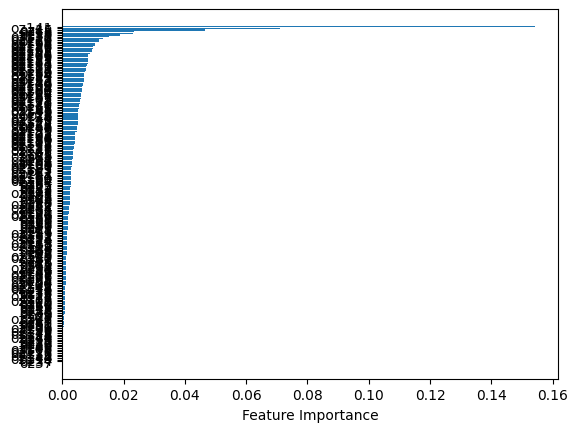

In [132]:
sort = rf.feature_importances_.argsort()
plt.barh(df.data.columns[sort], rf.feature_importances_[sort])
plt.xlabel("Feature Importance")

Мы получим столбчатый график, на котором по вертикали отложены все наши признаки, они подписаны слева вдоль вертикальной оси, по горизонтали - отложена относительная важность данного признака. Это условное число, которое показывает, насколько информативен данный признак для предсказания значения целевой переменной:

Из-за того, что у нас более 200 признаков, подпись мало читаются. Можете самостоятельно построить более читаемый график, отобрав, например, только 30 самых значимых признаков. Мы можем просто вывести значимость самых важных колонок датасета:

In [133]:
rf.feature_importances_[sort][-10:]

array([0.01186216, 0.01204575, 0.0131497 , 0.01523697, 0.0188803 ,
       0.02299281, 0.02340857, 0.04662117, 0.07110961, 0.15410087])

Обратите внимание, из-за того, что для построения графика мы сортировали массив по возрастанию, самые значимые признаки - в конце. Таким образом, нам нужны, например, 10 последних элементов в этом массиве. Вот что получаем:

Более интересна и полезна для нас информация о названиях самых важных признаков. Их тоже можно вывести:

In [134]:
df.data.columns[sort][-10:]

Index(['oz198', 'oz20', 'oz112', 'oz170', 'oz137', 'oz35', 'oz18', 'oz48',
       'oz15', 'oz141'],
      dtype='object')

Мы получаем соответствующее количество признаков, оказывающих наибольшее влияние на целевую переменную. Обратите внимание, что самые важные признаки будут в конце списка. Но для дальнейших целей нам не важен порядок колонок.

Теперь мы можем использовать эту информацию для удаления лишних данных из датасета. Количество самых важных признаков мы выбираем сами. Зачастую для этого используют "метод локтя". Можете самостоятельно попробовать разное количество признаков, мы сейчас возьмем 20:

In [135]:
trimmed = df.data[df.data.columns[sort][-20:]]
trimmed.head()

,oz157,oz159,oz169,oz201,oz155,oz195,oz162,oz179,oz158,oz197,oz198,oz20,oz112,oz170,oz137,oz35,oz18,oz48,oz15,oz141
0,0.000000,0.929724,0.352613,0.127564,0.752291,0.056880,0.319206,0.025609,0.800120,0.505899,0.039213,0.000000,0.000000,0.866163,0.000000,0.0,0.0625,0.312855,0.000000,0.041308
1,0.000281,0.944542,0.352625,0.475618,0.745984,0.287438,0.306084,0.024601,0.791224,0.683820,0.326584,0.242424,0.222222,0.866069,0.278945,0.4,0.0625,0.297041,0.282828,0.212274
2,0.001852,0.946121,0.352400,0.497968,0.753298,0.117431,0.406309,0.025104,0.798276,0.499219,0.204885,0.388889,0.000000,0.866224,0.000000,0.0,0.1250,0.288557,0.388889,0.063643
3,0.000158,0.945087,0.352497,0.134458,0.767469,0.145349,0.327848,0.025280,0.800965,0.630533,0.023469,0.095238,0.000000,0.865988,0.039437,0.1,0.0000,0.310692,0.111111,0.031193
4,0.000037,0.941644,0.352417,0.295913,0.741548,0.067583,0.329857,0.024934,0.802893,0.516053,0.111398,0.260870,0.000000,0.866283,0.000000,0.0,0.0625,0.286581,0.304348,0.063643


Не рекомендуется модифицировать исходную переменную, лучше создать новую копию датасета, в которую перенести только нужные колонки. Конечно, это нужно сделать и в обучающей и в тестовой части выборки. Либо, в исходном общем датасете, а затем повторить разбиение еще раз. Теперь все готово для того, чтобы построить модель на урезанном датасете:

In [136]:
X_train, X_test, y_train, y_test = train_test_split(trimmed, df.target, test_size=0.25, random_state=42)

better = LinearRegression()
better.fit(X_train, y_train)

print(bl_score)
better.score(X_test, y_test)

-1.6511340769310805


0.3615113323996876

Мы используем тот же класс моделей - линейную регрессию - чтобы различия в метрике были сопоставимы. И мы получаем гораздо более качественную модель. Метрика уже положительна, что свидетельствует о большом росте точности:

Можно изобразить график модели и визуально, чтобы убедиться в том, что он разительно отличается от графика, который мы получили ранее:

![](https://github.com/koroteevmv/ML_course/blob/main/ML5.4%20target/img/ml54-4.png?raw=true)

Регрессия еще далека от идеала, но уже значительно лучше случайности и показывает некоторый уровень эффективности, который может быть приемлемым в зависимости от прикладной задачи.

Мы, конечно, оценивали качество модели только по одной метрике. Можете самостоятельно сравнить значение других метрик качества регрессии на этих двух моделях. Убедитесь, что вторая модель лучше по любой выбранной метрике.

В данном примере сокращение количества столбцов в 10 раз, с 200 до 20, пошло только на пользу модели, так как избавило ее от лишних признаков, которые искусственно завышают сложность и вариативность функции гипотезы за счет введение большого числа коэффициентов. Другими словами, отбор признаков по важности оказывает регуляризирующее действие на модель.

##### Автоматизация отбора признаков

Конечно, отбор признаков - это довольно стандартная процедура при моделировании. В предыдущем примере мы все делали руками. Однако, в библиотеке sklearn есть встроенные средства выбора признаков. Познакомьтесь с ними в документации. Sklearn умеет автоматизировать как рекурсивное исключение и добавление признаков, и отбор по статистическим критериям, так и отбор по результатам обучения модели.

Давайте напомним себе о форме датасета:

In [137]:
(4450, 202)

(4450, 202)

Исходно у нас присутствует 202 признака. В sklearn есть специальный объект, SelectFromModel, который находится в пакете feature_selection. Познакомьтесь с документацией к этому классу и к другим классам из данного пакета. Работа с ними напоминает работу с другими классами преобразования данных в том плане, что используется подход fit-transform:

In [138]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(RandomForestRegressor(n_estimators=15)).fit(df.data, df.target)
X_trimmed = sfm.transform(df.data)
X_trimmed.shape

(4450, 55)

Обратите внимание, что мы передаем в этот объект вид модели машинного обучения, на основе которой будет производиться отбор признаков. При этом, методы fit() объекта SelectFromModel в том числе произведет обучение модели. Помните об этом, если используете ресурсоемкую модель. Данный объект можно настроить для использование уже обученной модели, без повторного запуска обучения.

Также обратите внимание, что мы используем данное преобразование на всем датасете. В дальнейшем мы опять разобьем его на обучающую и тестовую выборки. Однако, так как объект преобразования SelectFromModel сохраняется и "запоминает" нужные признаки, мы можем обучить его и уже после разбиения. В таком случае, метод transform() нужно будет вызвать и для обучающей и для тестовой выборки отдельно. Преобразование будет скоординированным.

Посмотрим, как данный код преобразовал данные:

У нас осталось 55 признаков. Это больше, чем мы использовали в прошлый раз. Решение об этом принимает сам алгоритм SelectFromModel. Его, конечно, тоже можно настроить. Но сейчас давайте проверим, как данная обработка скажется на эффективности модели. Для этого построим уже третью модель на этом датасете:

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X_trimmed, df.target, test_size=0.25, random_state=42)

better = LinearRegression()
better.fit(X_train, y_train)

print(bl_score)
better.score(X_test, y_test)

-1.6511340769310805


0.43498897582731344

Сы видим еще большее улучшение по метрикам:

In [140]:
-1.6511340762242592
0.4314653462618252

0.4314653462618252

Опять же, самостоятельно оцените данную модель и по другим метрикам регрессии. Особенно интересно ее сравнение со второй моделью. Но по метрика R-квадрат мы видим, что увеличение количества признаков до 55 не привело к переобучению модели. То же можно видеть и по графику.

![](https://github.com/koroteevmv/ML_course/blob/main/ML5.4%20target/img/ml54-5.png?raw=true)

Найдите самостоятельно, самое оптимальное количество признаков, которые следует оставить в модели для достижения наиболее высокой тестовой эффективности.

##### Устранение дисбаланса классов

Одна из самых частых проблем при построении моделей классификации на реальных данных - дисбаланс классов. Это ситуация, когда в датасете присутствует очень разное количество объектов, принадлежащих разным классам. Другими словами, это неравномерность распределения значений целевой переменной. При этом проблемой такой дисбаланс становится, когда объектов одного класса в несколько раз, а то и десятков раз больше чем другого. На практике, соотношение, например, 100 к 1 не является редкостью.

Это может быть проблемой при обучении моделей потому, что при подборе весов модель будет чаще видеть в обучающих примерах объекты мажоритарного или мажоритарных классов (то есть таких, объектов которых значительно больше). И их влияние на изменение параметров функции гипотезы будет превалировать над влиянием объектов миноритарных классов. В итоге модель может одновременно недообучиться на мажоритарных классах и переобучиться на миноритарных. При анализе результатов моделирования эту проблему проще всего выявить при рассмотрении отчета о классификации - объекты миноритарных классов распознаются значительно хуже.

Давайте обратимся к примеру. Возьмем датасет результатов психологического моделирования:

In [141]:
df = fetch_openml("balance-scale", version=1)

df.data.head()

,left-weight,left-distance,right-weight,right-distance
0,1,1,1,1
1,1,1,1,2
2,1,1,1,3
3,1,1,1,4
4,1,1,1,5


Этот набор данных не требует технической предварительной обработки для построения модели, поэтому сразу визуализируем распределение целевой переменной:

![](https://github.com/koroteevmv/ML_course/blob/main/ML5.4%20target/img/ml54-10.png?raw=true)

Мы видим, что объекты объединены в три класса, называемые "B", "R" и "L". Причем, объектов класса "B" примерно в шесть раз меньше, чем каждого из двух других. Это - миноритарный класс, а два других - мажоритарные. Для построения базовой модели, как всегда разделим выборку:

In [142]:
X_train, X_test, y_train, y_test = train_test_split(df.data, df.target, test_size=0.25, random_state=42, stratify=df.target)

Обратите внимание, что при разделении несбалансированных выборок за счет случайных ошибок мы можем существенно сместить форму этого распределения. Вполне вероятно, что объекты миноритарного класса вообще по прихоти случайности не попадут в тестовую выборку, или попадут в еще меньшей доле. Ил наоборот. Этого следует избегать, так как для адекватного оценивания качества модели, обучающая и тестовая выборки должны быть как можно более сходными по своим статистическим характеристикам. Все статистики в выборке мы проконтролировать не можем, но хотя бы должны убедиться, что распределение целевой переменной будет сходным.

Для этого применяют особый прием - стратификацию выборки. В функцию train_test_split можно передать специальный аргумент, который заставит ее учитывать распределение объектов по данной переменной. В нашем случае, мы используем целевую переменную для стратификации. Это гарантирует, что две подвыборки после разделения сохранять форму данного распределения. Убедиться можно на графике построив гистограмму значений целевой переменной в одной из выборок после разделения:

![](https://github.com/koroteevmv/ML_course/blob/main/ML5.4%20target/img/ml54-11.png?raw=true)

Теперь мы готовы построить базовую модель. Так как перед нами задача классификации, в качестве базовой выберем логистическую регрессию:

In [143]:
from sklearn.linear_model import LogisticRegression

baseline = LogisticRegression()
baseline.fit(X_train, y_train)
bl_score = baseline.score(X_test, y_test)
bl_score

0.8598726114649682

Базовая модель дает примерно 86% точности:

Опять же, можно оценивать модель и по другим метрикам. Более того, постановка задачи будет диктовать нам, какая метрика будет целевой, то есть на какую метрику мы должны ориентироваться в первую очередь при выборе и оценке моделей.

Так как мы исследуем проблему дисбаланса классов, обязательно надо построить отчет о классификации:

In [144]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, baseline.predict(X_test)))

              precision    recall  f1-score   support

           B       0.00      0.00      0.00        12
           L       0.87      0.92      0.89        73
           R       0.86      0.94      0.90        72

    accuracy                           0.86       157
   macro avg       0.58      0.62      0.60       157
weighted avg       0.80      0.86      0.83       157



На нем мы видим, что эффективность модели действительно разнится для разных классов:

Еще больше информации дает вывод матрицы классификации:

In [145]:
print(confusion_matrix(y_test, baseline.predict(X_test)))

[[ 0  6  6]
 [ 1 67  5]
 [ 0  4 68]]


Фактически, модель вообще ни разу не распознала правильно объект миноритарного класса. Поэтому невзвешенная оценка качества модели на самом деле ближе к отметке в 60%. Это не очень удовлетворительный результат.

Давайте посмотрим, удастся ли нам улучшить данную модель. Как всегда, есть несколько стратегий борьбы с дисбалансом классов. Здесь рассмотрим два: взвешивание классов и ресемплинг выборки.

Главная проблема дисбаланса классов в том, что модель недостаточно учитывает объекты миноритарных классов. Можно относительно просто это исправить, при обучении модели, придав больший "вес" таким редким объектам. Это называется, взвешивание классов. Для начала надо рассчитать "важность" или вес класса, который будет обратно пропорционален его доле в выборке. Можно сделать это и руками, но в библиотеке sklearn есть встроенная функция для этого:

In [146]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{'B': 4.216216216216216, 'L': 0.7255813953488373, 'R': 0.7222222222222222}

Предпоследняя строчка в этом коде нужна, чтобы правильно отформатировать получившиеся значения в словарь, где ключами являются метки классов, а значениями - вес соответствующего класса:

Мы видим, что вес миноритарного класса действительно вильно больше, чем двух других. Эту информацию можно передать непосредственно модели машинного обучения через параметр конструктора:

In [147]:
weighted = LogisticRegression(class_weight=class_weights)
weighted.fit(X_train, y_train)
print(bl_score)
weighted.score(X_test, y_test)

0.8598726114649682


0.9235668789808917

Такая модель будет сильнее изменять свои веса в ответ на объект миноритарного класса, пропорционально весу этого класса. На самом деле все немного сложнее, так как обучение идет методом пакетного градиентного спуска, в котором на каждом шаге обрабатывается несколько объектов выборки, но смысл именно в этом.

Оценим качество такой модели на отчете о классификации:

Мы видим, что точность модели возросла с 86% до 92%. Это очень существенное увеличение эффективности. Причем обратите внимание, что оценивали модель мы на той же тестовой выборке, в которой сохранено исходной неравномерное распределение. То есть это естественное повышение качества. При этом точность модели на этом миноритарном классе все равно немного ниже, чем на других. Это тоже естественно. Но разница уже далеко не такая огромная.

##### Oversampling

Но что делать, если конкретная модель не поддерживает взвешивание классов? Или по какой-то другой причине, такой способ либо не подходит, либо не дает нужного эффекта? Можно использовать ресемплинг - то есть случайную выборку из исходного датасета с выравниванием распределения по классам. Есть две стратегии. Оверсемплинг - это когда мы семплируем в выборку больше объектов мажоритарного класса с повторениями. Андерсемплинг - это исключение случайных объектов мажоритарных классов до выравнивания распределения. Есть гибридный подход - когда мы делаем и то и другое в определенных пропорциях. Кроме того, есть продвинутые техники генерации или аугментации данных для выравнивания распределения.

Покажем на простом примере как работает оверсемплинг. Подсчитаем точное количество объектов каждого класса в обучающей выборке:

In [148]:
y_train.value_counts()

class
R    216
L    215
B     37
Name: count, dtype: int64

Видим, что объектов миноритарного класса всего 37 против 216 - мажоритарного:

Для дальнейших манипуляций нам будет удобно объединить матрицу признаков и вектор целевой переменной в один датафрейм:

In [149]:
X_train["target"] = y_train

Теперь мы семплируем недостающее количество объектов миноритарного класса из нашего датасета с повторениями:

In [150]:
oversampled = X_train[X_train.target == "B"].sample(n=216-37, replace=True, ignore_index=True)

После этого нам остается только объединить эту новую выборку с исходной:

In [151]:
import pandas as pd
oversampled = pd.concat([X_train, oversampled])
print(oversampled.shape)
oversampled.head()

(647, 5)


,left-weight,left-distance,right-weight,right-distance,target
262,3,1,3,3,R
401,4,2,1,2,L
174,2,2,5,5,R
81,1,4,2,2,B
36,1,2,3,2,R


Построив распределение целевой переменной мы убеждаемся в том, что оно стало очень близко к равномерному:

![](https://github.com/koroteevmv/ML_course/blob/main/ML5.4%20target/img/ml54-11.png?raw=true)

Другими словами, мы просто добавили в обучающую выборку дубликаты объектов миноритарного класса в нужном объеме. В итоге, по задумке этого метода, при обучении модель будет чаще видеть такие объекты (пусть одни и те же) и будет подстраивать свои веса под них в том же темпе, что и под объекты мажоритарных классов. Проверим это. Опять разделим датафрейм на матрицу признаков и целевой вектор:

In [152]:
y_train_OS = oversampled.target
X_train_OS = oversampled.drop(["target"], axis=1)

И построим такую же модель логистической регрессии. Теперь никакое взвешивание классов не понадобится, мы сделали все руками:

In [153]:
OSmodel = LogisticRegression()
OSmodel.fit(X_train_OS, y_train_OS)
print(bl_score)
OSmodel.score(X_test, y_test)

0.8598726114649682


0.9235668789808917

При оценке качества этой модели получаем такую же картину, что и после взвешивания:

Данные стратегии производят очень схожий эффект на процесс обучения модели.

##### Дискретизация целевой переменной

Для освоения следующего приема обработки данных воспользуемся другим датасетом, но из того же репозитория. После чтения сразу подготовим его к моделированию:

In [154]:
df = fetch_openml("CPMP-2015-regression", version=1)
df.data.drop(["instance_id"], inplace=True, axis=1)
df.data = pd.get_dummies(df.data)
df.data.head()

C:\Users\ivant\AppData\Local\Temp\ipykernel_5564\1011001378.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.data.drop(["instance_id"], inplace=True, axis=1)


,repetition,stacks,tiers,stack.tier.ratio,container.density,empty.stack.pct,overstowing.stack.pct,overstowing.2cont.stack.pct,group.same.min,group.same.max,...,avg.l1.top.left.lg.group,cont.empty.grt.estack,pct.bottom.pct.on.top,algorithm_astar.symmulgt.transmul,algorithm_astar.symmullt.transmul,algorithm_idastar.symmulgt.transmul,algorithm_idastar.symmullt.transmul,runstatus_memout,runstatus_ok,runstatus_timeout
0,1,16,5,0.3125,0.6,0.0625,0.6250,0.909091,0,6,...,0.509615,0.1750,0.0,True,False,False,False,False,True,False
1,1,16,5,0.3125,0.6,0.0625,0.6250,0.909091,0,6,...,0.509615,0.1750,0.0,False,True,False,False,False,True,False
2,1,16,5,0.3125,0.6,0.0625,0.6250,0.909091,0,6,...,0.509615,0.1750,0.0,False,False,True,False,False,True,False
3,1,16,5,0.3125,0.6,0.0625,0.6250,0.909091,0,6,...,0.509615,0.1750,0.0,False,False,False,True,False,False,True
4,1,16,5,0.3125,0.6,0.1875,0.5625,1.000000,0,7,...,0.663462,0.3375,0.0,True,False,False,False,True,False,False


Это набор данных о бенчмарке решения математической проблемы нахождения оптимальной сортировки на контейнерной площадке. В этом наборе нам более всего важно распределение целевой переменной:

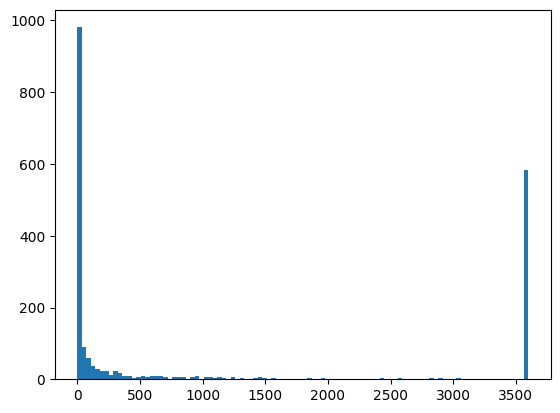

In [155]:
plt.hist(df.target, 100)
_ = plt.plot()

Мы видим, что целевая переменная имеет численный вид (то есть перед нами проблема регрессии), и при этом, распределена очень неравномерно:

![](https://github.com/koroteevmv/ML_course/blob/main/ML5.4%20target/img/ml54-6.png?raw=true)

Это не красивое около-нормальное распределение из предыдущего примера. Это очень очень несбалансированное двухмодальное распределение. Есть большое количество объектов в датасете, у которых значение целевой переменной близко к 0, чуть меньшее, но тоже большое количество объектов, у которых оно близко к максимальному (порядка 3 500), и очень мало объектов с промежуточными значениями.

Такое странное неравномерное распределение может повлечь проблемы при моделировании. Проблема сходная с дисбалансом классов, но для регрессии. Модель будет при своем обучении очень часто видеть объекты со схожим значениями целевой переменной и очень редко - объекты с промежуточными. В итоге модель может не научится распознавать такие промежуточные объекты.

Покажем, как можно уменьшить влияние такого распределения. Но сначала разделим датасет на обучающую и тестовую выборки, чтобы отдельно обработать их уже после разделения:

In [156]:
X_train, X_test, y_train, y_test = train_test_split(df.data, df.target, test_size=0.25, random_state=42)

Как мы уже упоминали, разделение датасета может внести случайный ошибки выборки, что особенно критично при неравномерных распределениях. Поэтому важно убедиться, что в обеих частях распределение сохранило свою форму, хотя бы в общих чертах:

Мы можем исправить неравномерность распределения разными способами, среди которых также ресемплирование выборки, как и в случае с классификацией. Но здесь покажем другой подход - дискретизацию целевой переменной. Этот способ заключается в том, что мы объединяем значения целевой переменной в категории - bins - поэтому такой способ часто называют биннинг.

Группировать объекты можно опять же по-разному. Для автоматизации этой процедуры в библиотеке sklearn есть специальный объект - KBinsDiscretizer, который находится в пакете preprocessing. Воспользуемся им и создадим, например, пять групп:

In [ ]:
y_binned = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="uniform").fit_transform(pd.DataFrame(y_train))

Группировка объектов означает, что мы переходим к категориальному типу в целевой переменной. Каждая категория будет обозначать некоторый диапазон исходных значений. При этом категории нумеруются последовательно, как при применении OrdinalEncoder при кодировании категориальных признаков. Но в этом случае, применение такой кодировки оправдано, так как эти категории, обозначая диапазоны значений численной шкалы, имеют естественный порядок. Вот как выглядят значения целевой переменной после дискретизации:

Самая простая стратегия биннинга, которая применяется в этом объекте по умолчанию - равномерная. Она делит существующий диапазон значений на указанное количество равных по величине поддиапазонов, каждый из которых кодируется последовательным натуральным числом. По сути, мы просто укрупняем целевую переменную. Если раньше у нас было произвольно большое количество значений, потенциально равное количеству объектов в выборке, то после дискретизации остается указанное количество, в нашем примере - пять. Давайте визуализируем получившееся распределение:

![](https://github.com/koroteevmv/ML_course/blob/main/ML5.4%20target/img/ml54-8.png?raw=true)

Естественно, так как мы используем равномерные диапазоны, в крайних поддиапазонах соберутся большинство объектов выборки. Мы это видим на графике - столбцы укрупнились, но неравномерность распределения никуда не делась. В случае таких сильно неравномерных распределений нам больше подойдет другая стратегия - квантильная дискретизация, при которой длина диапазонов выбирается таким образом, чтобы в каждом из них оказалось примерно по одинаковому количеству объектов выборки:

In [158]:
y_binned = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile").fit_transform(pd.DataFrame(y_train))

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Такой способ полностью исключит неравномерность распределения. На графике хорошо видно, что теперь каждой категории соответствует одинаковое количество объектов:

![](https://github.com/koroteevmv/ML_course/blob/main/ML5.4%20target/img/ml54-9.png?raw=true)

Обратите внимание, что на диаграмме четыре столбика, причем последний в два раза выше. Это всего лишь артефакт визуализации, в которой две последние категории объединились. Самостоятельно поэкспериментируйте с визуализацией и выберите такой график, который корректно показывает получившееся распределение.

#### Задания для самостоятельного выполнения

1. Исследуйте связь между количеством самых важных признаков, которые использует модель для обучения и тестовой точностью получившейся модели. Обучите несколько моделей с разным количеством наиболее важных признаков. Постройте график зависимости точности модели от количества признаков. Сделайте вывод.
1. Используйте другие методы отбора признаков:
	1. Исключение низкодисперсных признаков;
	1. Исключение по парным стаистическим критериям (хи-квадрат, тест Фишера, коэффициент корреляции, информационный критерий);
	1. Рекурсивное исключение признаков;
	1. Последовательное включение признаков;
	1. Исключение по L1-норме (гребневой регрессии).
1. Изучите возможности библиотеки [imbalanced-learn](https://imbalanced-learn.org/stable/). Примените на данном примере возможности данной библиотеки для оверсемплинга и андерсемплинга выборки.
1. Исследуйте влияние дискретизации целевой переменной на качество модели. Используйте уже продемострированный подход - построение базовой модели (baseline) и сравнение модели после обработки данных с базовой. Проверьте разное количество категорий, а также разные стратегии группировки. Сделайте выводы. Обратите внимание, что после биннинга целевой переменной она стала категориальной. А значит, задача превратилась в задачу классификации.

##### 1. Исследуйте связь между количеством самых важных признаков, которые использует модель для обучения и тестовой точностью получившейся модели. Обучите несколько моделей с разным количеством наиболее важных признаков. Постройте график зависимости точности модели от количества признаков. Сделайте вывод.

In [159]:
# Загрузка данных
df = fetch_openml("CPMP-2015-regression", version=1, as_frame=True)
X = df.data.drop(columns=["instance_id"])
X = pd.get_dummies(X)
y = df.target.astype(float)

In [160]:
# Разбиение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [161]:
# Подбор полной модели и извлечение важностей
rf_full = RandomForestRegressor(n_estimators=100, random_state=42)
rf_full.fit(X_train, y_train)
importances = pd.Series(rf_full.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

In [162]:
# Для разных k (число топ-признаков) обучаем новую RF и считаем R²
results = []
for k in range(5, len(importances)+1, 5):
    top_k = importances.index[:k]
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train[top_k], y_train)
    score = model.score(X_test[top_k], y_test)
    results.append((k, score))

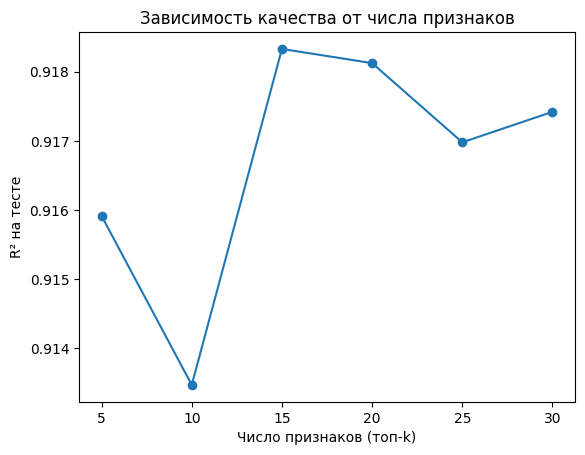

In [163]:
# Визуализация
df_res = pd.DataFrame(results, columns=["num_features", "r2"])
plt.plot(df_res.num_features, df_res.r2, marker='o')
plt.xlabel("Число признаков (топ-k)")
plt.ylabel("R² на тесте")
plt.title("Зависимость качества от числа признаков")
plt.show()

##### 2. Используйте другие методы отбора признаков:

###### 2.1. Удаление низкодисперсных признаков

In [164]:
methods = {}

vt = VarianceThreshold(threshold=0.01).fit(X_train)
methods["VarianceThreshold"] = X_train.columns[vt.get_support()]

###### 2.2. Парные статистические критерии

In [172]:
from sklearn.feature_selection import SelectKBest, chi2

# 1) Дискретизируем y_train в 5 равных квантилей
kbd_fs = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile")
y_train_binned_fs = kbd_fs.fit_transform(y_train.values.reshape(-1,1)).ravel()

# 2) Теперь можно применить χ²-отбор к признакам
#    (X_train—бинаризованные категории уже не нужны: у вас dummies, так что всё ≥0)
skb_chi2 = SelectKBest(chi2, k=10).fit(X_train, y_train_binned_fs)
selected_features_chi2 = X_train.columns[skb_chi2.get_support()]

print("Признаки, отобранные SelectKBest(chi2):")
print(selected_features_chi2.tolist())

Признаки, отобранные SelectKBest(chi2):
['stacks', 'tiers', 'group.same.max', 'top.good.max', 'top.good.mean', 'top.good.stdev', 'bflb', 'runstatus_memout', 'runstatus_ok', 'runstatus_timeout']


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [173]:
methods["SelectKBest_chi2"] = selected_features_chi2
methods["SelectKBest_f_regression"] = X_train.columns[SelectKBest(f_regression, k=10).fit(X_train, y_train).get_support()]
methods["SelectKBest_mutual_info"] = X_train.columns[SelectKBest(mutual_info_regression, k=10).fit(X_train, y_train).get_support()]

###### 2.3. Рекурсивное исключение (RFE)

In [166]:
rfe = RFE(RandomForestRegressor(n_estimators=50), n_features_to_select=10).fit(X_train, y_train)
methods["RFE"] = X_train.columns[rfe.support_]

###### 2.4. Последовательное включение (forward SFS)

In [167]:
sfs = SequentialFeatureSelector(
    RandomForestRegressor(n_estimators=50), 
    n_features_to_select=10, direction="forward"
).fit(X_train, y_train)
methods["SequentialFS"] = X_train.columns[sfs.get_support()]

###### 2.5. L1-норма (Lasso + SelectFromModel)

In [168]:
lasso = Lasso(alpha=0.01).fit(X_train, y_train)
sfm = SelectFromModel(lasso, prefit=True)
methods["L1_Lasso"] = X_train.columns[sfm.get_support()]

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.227e+06, tolerance: 3.824e+05
  model = cd_fast.enet_coordinate_descent(


###### Оценим каждую выборку

In [174]:
scores = {}
for name, feats in methods.items():
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train[feats], y_train)
    scores[name] = model.score(X_test[feats], y_test)

print("R² по методам отбора:")
for name, score in scores.items():
    print(f"{name}: {score:.4f}")

R² по методам отбора:
VarianceThreshold: 0.9224
RFE: 0.9135
SequentialFS: 0.9065
L1_Lasso: 0.9177
SelectKBest_chi2: 0.9167
SelectKBest_f_regression: 0.9098
SelectKBest_mutual_info: 0.9138


##### 3. Изучите возможности библиотеки [imbalanced-learn](https://imbalanced-learn.org/stable/). Примените на данном примере возможности данной библиотеки для оверсемплинга и андерсемплинга выборки.

In [170]:
# Для демонстрации сначала дискретизируем y в 3 класса
kbd = KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="quantile")
y_train_bin = kbd.fit_transform(y_train.values.reshape(-1,1)).ravel()

print("Изначальное распределение классов:", Counter(y_train_bin))

# SMOTE (oversampling)
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X_train, y_train_bin)
print("После SMOTE:", Counter(y_sm))

# Random UnderSampler
rus = RandomUnderSampler(random_state=42)
X_ru, y_ru = rus.fit_resample(X_train, y_train_bin)
print("После RandomUnderSampler:", Counter(y_ru))

Изначальное распределение классов: Counter({2.0: 527, 1.0: 527, 0.0: 527})
После SMOTE: Counter({2.0: 527, 1.0: 527, 0.0: 527})
После RandomUnderSampler: Counter({0.0: 527, 1.0: 527, 2.0: 527})


##### 4. Исследуйте влияние дискретизации целевой переменной на качество модели. Используйте уже продемострированный подход - построение базовой модели (baseline) и сравнение модели после обработки данных с базовой. Проверьте разное количество категорий, а также разные стратегии группировки. Сделайте выводы. Обратите внимание, что после биннинга целевой переменной она стала категориальной. А значит, задача превратилась в задачу классификации.

In [171]:
# Дискретизуем тестовую выборку
y_test_bin = kbd.transform(y_test.values.reshape(-1,1)).ravel()

# Обучаем классификатор
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train_bin)
y_pred = clf.predict(X_test)

# Отчёт по классификации
print(classification_report(y_test_bin, y_pred))


              precision    recall  f1-score   support

         0.0       0.70      0.77      0.74       164
         1.0       0.61      0.69      0.65       154
         2.0       0.99      0.82      0.90       209

    accuracy                           0.77       527
   macro avg       0.77      0.76      0.76       527
weighted avg       0.79      0.77      0.78       527



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


###### 

#### Контрольные вопросы

1. Какие модели лучше всего можно использовать для отбора признаков? Почему другие нельзя или нежелательно?
1. Зачем нужен этап отбора признаков? В каких случаях без него не обобйтись? А в каких его можно пропустить?
1. Какие есть методы отбора признаков? Найдите и опишите не менее пяти.
1. Какие есть стратегии устранения дисбаланса классов? В каких случаях стоит применять их и от чего зависит выбор стратегии?
1. Какие модели машинного обучения из библиотеки sklearn поддерживают веса классов?
1. Зачем использовать дискретизацию непрерывной целевой переменной? В каких случаях это оправданно, а в каких - нет?
1. Почему дискретизацию целевой переменной нужно делать только после разделения на тестовую и обучающую подвыборки? Что такое утечка данных?

#### Дополнительные задания
1. Повторите приведенный в данной работе анализ полностью на другом датасете. Сделайте вывод.
1. Используйте продвинутые алгоритмы дискретизации целевой переменной, например, CART.
1. Оформите алгоритм обработки данных как конвейер (pipeline) sklearn.
1. Изучите и примените продвинутые стратегии оверсемплинга выборки: SMOTE, ASMO, ADASYN. Поясните механизм их работы и применимость в разных задачах.
1. Изучите и примените метод андерсемплинга выборки, основанный на Tomek Links. Сделайте вывод о его применимости к разным задачам.
1. Для датасета по классификации модифицируйте предсказание второй модели так, чтобы вернуть постановку задачи регрессии. Для этого каждой категории присвойте численное значение. Это можно сделать, вычислив, например, медиану. Теперь можно считать, что модель предсказывает не метку категории, а конкретное численное значение. Как следствие, для оценки такой модели можно использовать метрики качества регрессии. Сравните метрики до и после преобразования.